# Text Mining Project on Korea Herald

# Load Data

In [1]:
import json
import pandas as pd
import gzip
import numpy as np

data_path = '../data/koreaherald_1517_#.json.gz'

df_data = pd.DataFrame()

for i in range(8):
  p = data_path.replace('#',str(i))
  with gzip.open(p,'rb') as f:
    data = pd.DataFrame.from_dict(json.load(f))
  df_data = df_data.append(data,ignore_index=True)

# clean up column names
df_data = df_data.rename(columns={" author": "author",
                        " time": "time",
                        " description": "description",
                        " body": "body",
                        " section": "section",
                       })
# preview data
print('Number of docs: {}'.format(df_data.shape[0]))
df_data.dtypes

Number of docs: 3000


title          object
author         object
time           object
description    object
body           object
section        object
dtype: object

# Pre-Processing

Here we apply:
- tokenisation
- lemmatisation
- normalisation

(optional) Bigrams

In [2]:
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))

def tokenise_pipeline(doc):
  doc = doc.lower()  # Convert to lowercase.
  tokens = tokenizer.tokenize(doc) # split into words
  # TODO: remove stopwords
  tokens = [token for token in tokens if not token.isnumeric()] # remove numbers
  tokens = [token for token in tokens if token not in stop_words]
  tokens = [token for token in tokens if len(token) > 2] # remove words of only 1 letter
  tokens = [lemmatizer.lemmatize(token) for token in tokens] # lemmatisation
  return tokens

In [3]:
df_data['body_tokenised'] = df_data['body'].apply(tokenise_pipeline)

In [4]:
from gensim.models import Phrases

docs = [doc for doc in df_data['body_tokenised']]
bigrams = Phrases(docs, min_count=20) # keeps only phrases that appear >= 20 times in corpus.

def add_bigrams(doc):
  for token in bigrams[doc]:
    if '_' in token:
      doc.append(token)
  return doc

df_data['body_tokenised'] = df_data['body_tokenised'].apply(add_bigrams)

In [5]:
from gensim.corpora import Dictionary

dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=20, no_above=0.5) # filter words that occur in less than 20 docs or more than 50% docs

print('Number of unique tokens: {}'.format(len(dictionary)))
print('Number of documents: {}'.format(len(docs)))

Number of unique tokens: 4015
Number of documents: 3000


# Vectorization

In [6]:
from gensim.models import TfidfModel

corpus = [dictionary.doc2bow(doc) for doc in df_data['body_tokenised']]
tfidf = TfidfModel(corpus)
df_data['body_bow'] = df_data['body_tokenised'].apply(dictionary.doc2bow)
df_data['body_tfidf'] = df_data['body_bow'].apply(lambda doc : tfidf[doc])
df_data['title_tfidf'] = df_data['title_bow'].apply(lambda doc : tfidf[doc])

# LDA

In [8]:
from gensim.models import LdaModel

temp = dictionary[0] # to 'load' dictionary
id2word = dictionary.id2token

# parameters
feature = 'body_bow' # lda uses bow
corpus = df_data[feature].values
num_topics = 20

model = LdaModel(
  corpus = corpus,
  id2word = id2word,
  chunksize = 2000,
  alpha = 'auto',
  eta = 'auto',
  iterations = 400,
  num_topics = num_topics,
  passes = 20,
  eval_every = None
  )

## Assign Topics to Docs

In [9]:
def argmax(ls):
  return max(ls, key = lambda item: item[1])

df_data['topic'] = df_data[feature].apply(lambda x : argmax(model.get_document_topics(x))[0])
df_data['topic_confidence'] = df_data[feature].apply(lambda x : argmax(model.get_document_topics(x))[1])

,title,author,time,description,body,section,body_tokenised,body_bow,body_tfidf,topic,topic_confidence
0,A snapshot of multiculturalism in South Korea,Lee Sun-young,2018-01-01 17:07:00,With birthrates persistently low and the senio...,With birthrates persistently low and the senio...,Social affairs,"[birthrate, persistently, low, senior, populat...","[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 2...","[(0, 0.07843075821931803), (1, 0.0769504257126...",14,0.615513
1,[Weekender] Korea’s dynamic 2017,Choi He-suk,2018-01-01 13:22:00,From North Korea’s nuclear weapons program nea...,From North Korea’s nuclear weapons program nea...,Social affairs,"[north, korea, nuclear, weapon, program, neari...","[(5, 3), (6, 1), (10, 1), (18, 1), (19, 1), (2...","[(5, 0.1331227079332916), (6, 0.03357377678525...",0,0.239122
2,People's Party members support Ahn's push for ...,Yonhap,2017-12-31 16:18:00,The leader of the center-left People's Party g...,The leader of the center-left People's Party g...,Politics,"[leader, center, left, people, party, garnered...","[(10, 1), (19, 1), (25, 1), (36, 2), (46, 1), ...","[(10, 0.03157498321748018), (19, 0.02636677613...",2,0.922439
3,[Newsmaker] Panamanian vessel probed over susp...,Yonhap,2017-12-31 14:55:00,PYEONGTAEK -- South Korea has seized and insp...,PYEONGTAEK -- South Korea has seized and insp...,North Korea,"[pyeongtaek, south, korea, seized, inspected, ...","[(21, 1), (25, 2), (34, 1), (50, 2), (64, 1), ...","[(21, 0.045114819192250084), (25, 0.0318054216...",11,0.275745
4,Hong Kong ship crew questioned in S. Korea for...,AFP,2017-12-30 15:44:00,The crew of a Hong Kong-registered ship have b...,The crew of a Hong Kong-registered ship have b...,North Korea,"[crew, hong, kong, registered, ship, detained,...","[(6, 1), (10, 1), (19, 1), (20, 2), (21, 1), (...","[(6, 0.026422739681800804), (10, 0.03928586005...",0,0.358625
...,...,...,...,...,...,...,...,...,...,...,...
2995,Eyes on validity of Samsung merger,Bak Se-hwan,2017-08-27 16:38:00,Following the conviction of Samsung Group heir...,Following the conviction of Samsung Group heir...,Social affairs,"[following, conviction, samsung, group, heir, ...","[(14, 1), (22, 1), (36, 3), (38, 1), (39, 1), ...","[(14, 0.05495662033819852), (22, 0.01225854056...",12,0.716438
2996,Number of visitors to overpass-turned-park top...,Yonhap,2017-08-27 16:14:00,The number of visitors to the overpass-turned-...,The number of visitors to the overpass-turned-...,Social affairs,"[number, visitor, overpass, turned, park, seou...","[(6, 1), (7, 1), (11, 1), (21, 1), (30, 1), (3...","[(6, 0.07206881131731371), (7, 0.0642308923464...",10,0.594116
2997,N. Korean propaganda leaflets on ‘missile succ...,Kim Min-joo,2017-08-27 16:01:00,"Propaganda leaflets, presumably distributed by...","Propaganda leaflets, presumably distributed by...",North Korea,"[propaganda, leaflet, presumably, distributed,...","[(7, 2), (22, 1), (39, 1), (40, 1), (58, 1), (...","[(7, 0.13393660211519515), (22, 0.037879601252...",9,0.393152
2998,Row over smoking indoors ends in attempted murder,Kim Min-joo,2017-08-27 15:58:00,A 51-year-old man has been sentenced to three ...,A 51-year-old man has been sentenced to three ...,Social affairs,"[year, old, man, sentenced, three, year, six, ...","[(18, 1), (22, 1), (39, 1), (40, 1), (42, 1), ...","[(18, 0.05193491687034624), (22, 0.03101002732...",17,0.646718


In [10]:
len(model.show_topics(num_topics=20))

20

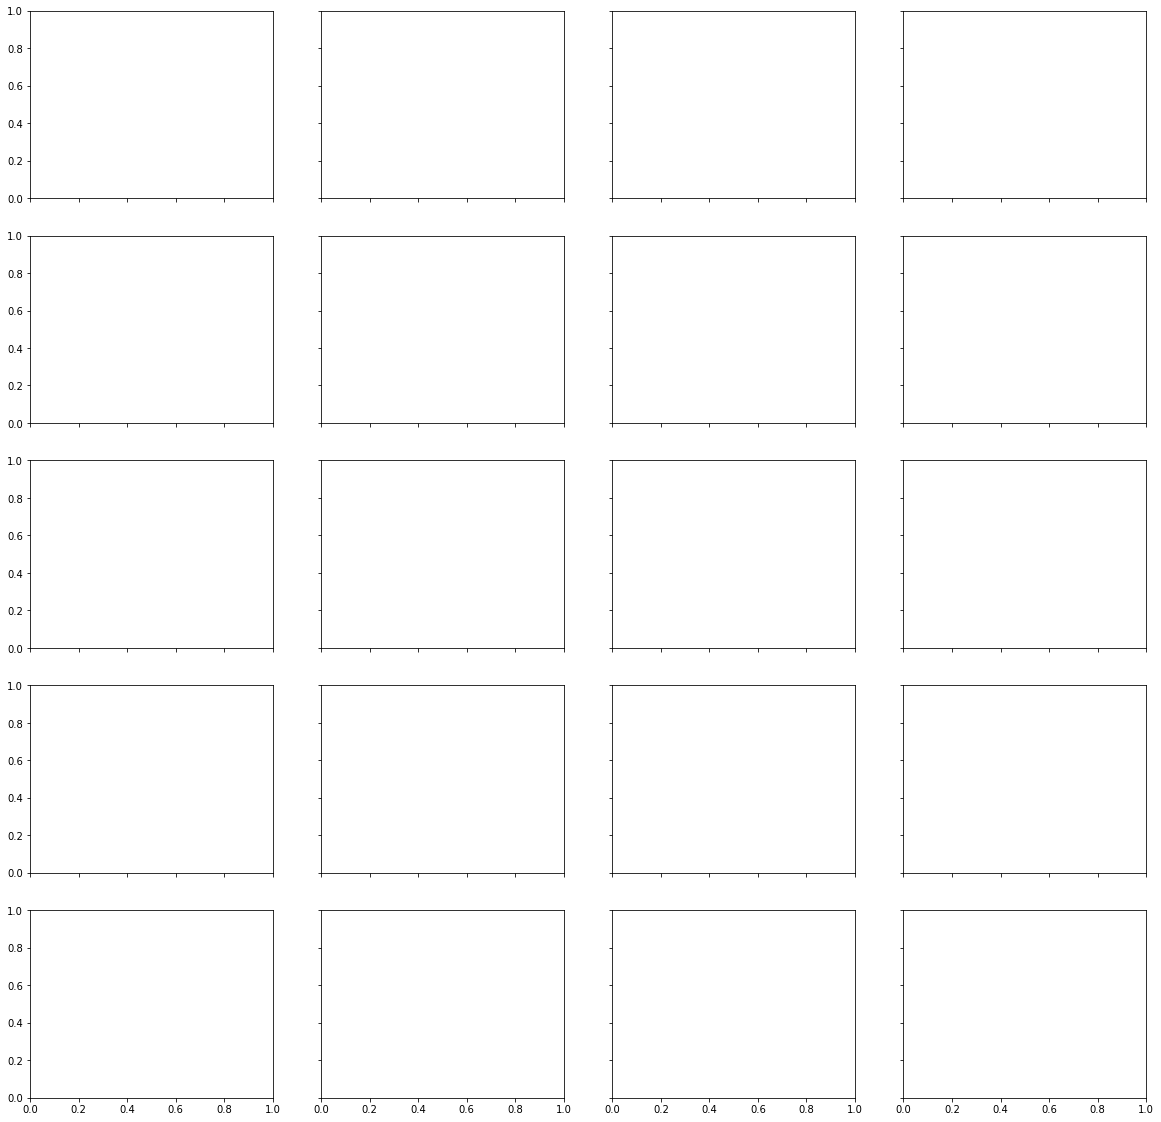

In [11]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
%matplotlib inline

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cols = cols * 2

max_words = 15

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=max_words,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False,num_topics=num_topics, num_words=max_words)

fig, axes = plt.subplots(5, 4, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# NER Code

In [14]:
import spacy
nlp = spacy.load("en")

labels = ['ORG', 'LOC', 'PERSON']
def get_entities(txt):
    doc = nlp(txt)
  
    #doc now contains all the entities identified
    NER_list = [((ent.text),ent.label_) for ent in doc.ents]

    #this line is to remove duplicate entities
    NER_list = list(dict.fromkeys(NER_list))

    #converting list of tuples to list of lists for easier manipulation later
    NER_list_final = [list(entity) for entity in NER_list]

    #Filtering for the entity labels that we are interested in.
    entities = {}
    entities[labels[0]] = [entity[0] for entity in NER_list_final if entity[1] == labels[0]]
    entities[labels[1]] = [entity[0] for entity in NER_list_final if entity[1] == labels[1]]
    entities[labels[2]] = [entity[0] for entity in NER_list_final if entity[1] == labels[2]]

    return entities

dict_values([['U.N.'], [], ['Donald Trump', 'Barack Obama']])


# Related Issue Event Tracker

In [ ]:
from nltk.corpus import wordnet as wn

# Method to extract hypernym of a word
def hypernym_extract(string):
    string += '.n.01'
    hyper = wn.synset(string).hypernyms()
    return str(hyper[0])[str(hyper[0]).index('\'')+1:str(hyper[0]).index('.')]

# Method to remove duplicates of elements in a list
def unique_ele(alist):
    s = set(alist)
    alist = list(s)
    return alist

# Check if all values in ner_dic are present in the body
def NER_check(ner_dic, disc_words, score):
    ner = list(get_all_values(ner_dic))
        
    if len(ner) > 0 and len(ner) < 15:
        for i in range(len(ner)):
            ner[i] = ner[i].lower()
        if all(word in disc_words for word in ner):
            return np.nan
        else:
            return score
    else:
        return score
    
# Get list of all the values from a dictionary
def get_all_values(d):
    if isinstance(d, dict):
        for v in d.values():
            yield from get_all_values(v)
    elif isinstance(d, list):
        for v in d:
            yield from get_all_values(v)
    else:
        yield d 

# Extract all discriminative words from each topic to represent an issue
issues_all = {}
for i in range(len(topics)):
    k_words = []
    for j in range(max_words):
        k_words.append(topics[i][1][j][0])
    issues_all[i] = k_words


# Extract Top k discriminative words from each topic to represent an issue
issues = {}
k = 5
for i in range(len(topics)):
    k_words = []
    for j in range(k):
        k_words.append(topics[i][1][j][0])
    issues[i] = k_words

# Append hypernyms of values in issues
for i in range(len(issues)):
    for j in range(k):
        try:
            issues[i].append(hypernym_extract(issues[i][j]))
        except:
            print ("Hypernym of '{}' is not found.".format(issues[i][j]))

# Remove duplicate words in the list of 'body_tokenised' column
df_unique_tokens = df_data.copy()
df_unique_tokens['body_tokenised'] = df_unique_tokens['body_tokenised'].apply(unique_ele)

# Add NER as columns for the entities recognized
df_unique_tokens['NER'] = df_unique_tokens['body'].apply(lambda row : get_entities(row))

# Get number of matching words in the whitelist
for  i in range(len(issues)):
    
    # The more same words that a document contains as that in whitelist, 
    # the higher chance that the document is related to the issue(topic cluster)
    whitelist = issues[i]
    
    # Assign name of the columns which will contain the scores
    issue_index = 'issue#'
    ind = issue_index.replace('#',str(i))
    
    # Create a dataframe containing docs outside ith topic cluster
    df_docs_outside_cluster = df_unique_tokens[df_unique_tokens['topic']!=i].copy()
    # Give score based on the number of words in whitelist appearing in the body
    df_unique_tokens[ind] = df_docs_outside_cluster['body_tokenised'].apply(lambda row:len(set(whitelist) & set(row)))
    # Give score of NaN to the documents with NER matching all words 
    # in the ith topic cluster to avoid extracting the same event
    df_unique_tokens[ind] = df_unique_tokens.apply(lambda row : NER_check(row['NER'], issues_all[i], row[ind]), axis=1)   
    
    # Sort and copy top 10 rows
    df_temp = df_unique_tokens.sort_values(ind, ascending = False).head(10).copy()
    
    # Assign title of docuemnts as the name of an event
    events = list(df_temp['title'])
    # Create a list of NERs of top 10 rows
    detail_info = list(df_temp['NER'])
    
    # Print output in desired format
    print ('Issue: ' + ' '.join(issues[i]))
    print ('Event: ' + ','.join(events))
    for index in range(10):
        print ('\nDetail Information:')
        print (events[index])
        print ('\t- ' + 'Person ({})'.format(', '.join(detail_info[index]['PERSON'])))
        print ('\t- ' + 'Organization ({})'.format(', '.join(detail_info[index]['ORG'])))
        print ('\t- ' + 'Places ({})'.format(', '.join(detail_info[index]['LOC'])))

Hypernym of 'nuclear' is not found.
Hypernym of 'north_korea' is not found.
Hypernym of 'north_korea' is not found.
Hypernym of 'north_korea' is not found.
Hypernym of 'lee' is not found.
Hypernym of 'new' is not found.
Hypernym of 'japan' is not found.
Hypernym of 'nuclear' is not found.
Hypernym of 'gyeonggi' is not found.
Hypernym of 'kim' is not found.
Hypernym of 'north_korea' is not found.
Hypernym of 'ballistic' is not found.
Hypernym of 'lee' is not found.
Hypernym of 'moon' is not found.
Hypernym of 'kim' is not found.
Hypernym of 'moon' is not found.
Hypernym of 'dae' is not found.
Hypernym of 'cheong' is not found.
Hypernym of 'cheong_dae' is not found.
